In [50]:
# Importing required Libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [51]:
# Reading csv files
transactions = pd.read_csv('Transactions.csv')
customers = pd.read_csv('Customers.csv')

In [52]:
# Merge datasets
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

In [53]:
merged_data = merged_data.query('SignupDate < TransactionDate')

In [54]:
# Feature engineering
customer_features = merged_data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    total_quantity=('Quantity', 'sum'),
    num_transactions=('TransactionID', 'count'),
    num_products=('ProductID', 'nunique')
).reset_index()

In [55]:
# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_features.iloc[:, 1:])

# Save feature names for reference
feature_names = customer_features.columns[1:]

In [57]:
# K-Means clustering
cluster_count = 4
kmeans = KMeans(n_clusters= cluster_count, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original DataFrame
customer_features['Cluster'] = clusters


In [58]:
# Calculate clustering metrics
db_index = davies_bouldin_score(features_scaled, clusters)
silhouette_avg = silhouette_score(features_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(features_scaled, clusters)

# Print metrics
print(f"Number of Clusters: {cluster_count}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Number of Clusters: 4
Davies-Bouldin Index: 0.8985
Silhouette Score: 0.3488


#### Visualizing the Clusters

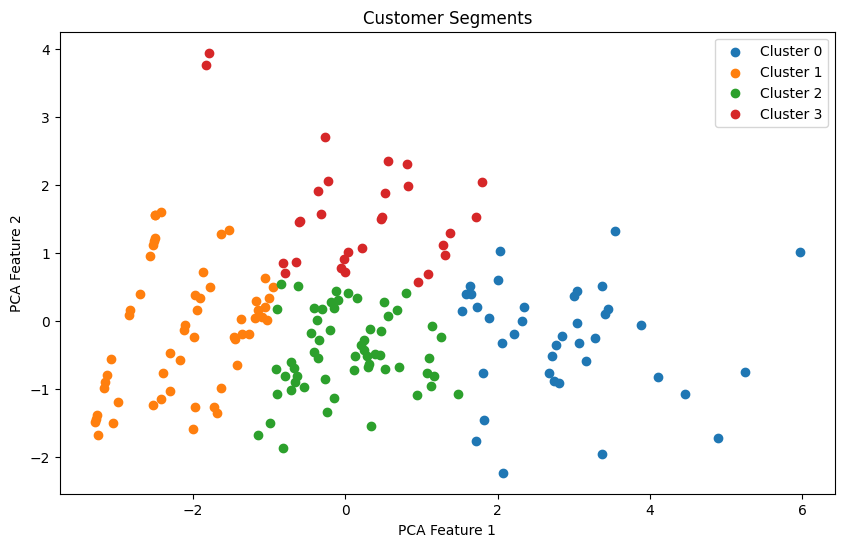

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster_id in set(clusters):
    cluster_points = features_2d[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')

plt.title("Customer Segments")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend()
plt.show()


In [64]:
# Calculate summary statistics for each cluster
cluster_summary = customer_features.groupby('Cluster').agg(
    avg_total_spending=('total_spending', 'mean'),
    avg_transaction_value=('avg_transaction_value', 'mean'),
    avg_total_quantity=('total_quantity', 'mean'),
    avg_num_products=('num_products', 'mean'),
    avg_num_transactions=('num_transactions', 'mean')
)

cluster_summary

,avg_total_spending,avg_transaction_value,avg_total_quantity,avg_num_products,avg_num_transactions
Cluster,,,,,
0,5550.087692,726.686323,20.102564,7.487179,7.769231
1,1117.736786,553.316012,4.446429,1.964286,2.000000
2,2698.781695,581.205119,11.152542,4.610169,4.677966
3,3860.410690,1069.830259,11.172414,3.620690,3.724138


### Cluster Insights Summary:
**Cluster 0** (High-Value, Engaged Customers)  
- Key Traits: Highest spending, most frequent transactions, largest product diversity.
- Action: Focus on retention with loyalty programs and exclusive offers.

**Cluster 1** (Low-Value, Infrequent Customers)
- Key Traits: Lowest spending, least transactions, minimal product diversity.
- Action: Target with promotions or personalized campaigns to increase engagement.

**Cluster 2** (Moderate Spenders)
- Key Traits: Moderate spending, steady transaction frequency, decent product variety.
- Action: Encourage higher spending via upselling or cross-selling strategies.

**Cluster 3** (High-Spenders with Lower Frequency)
- Key Traits: High transaction value but less frequent purchases and lower product variety.
- Action: Offer subscription models or discounts to encourage repeat purchases.


#### Elbow Method for finding optimal clusters count

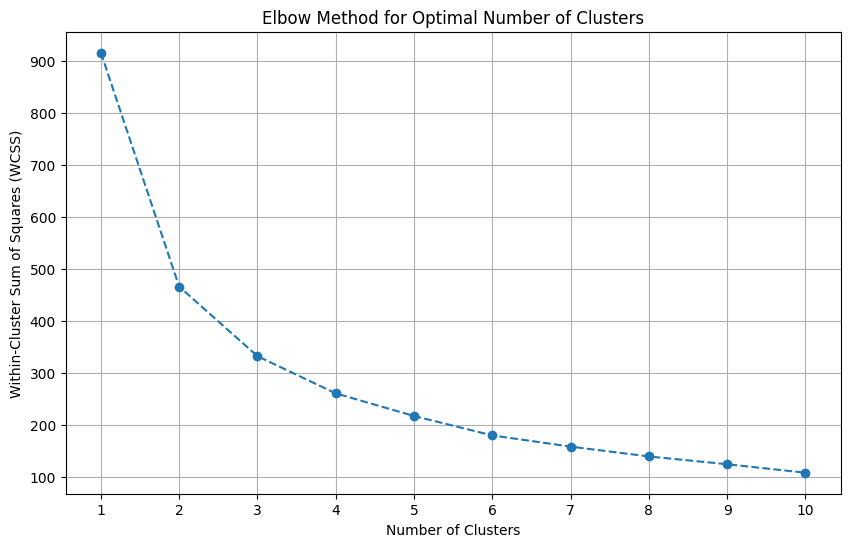

In [ ]:
# Define a range for the number of clusters
cluster_range = range(1, 11)  # Trying between 2 and 10 clusters
wcss = []  # List to store WCSS values for each k

# Compute WCSS for each value of k
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)  # WCSS is stored in the inertia_ attribute

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(cluster_range)
plt.grid()
plt.show()
